In [1]:
import os
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from spacy.tokens import Token
from spacy.language import Language
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from matplotlib.patches import FancyBboxPatch
import re
import pyLDAvis
import pyLDAvis.gensim_models as gensimvi
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math
colors = ["#06005c",
"#6b0062",
"#ac0059",
"#dc2246",
"#f8682c",
"#ffa600"]

# DETECT NON ALPHANUMERIC
def get_excluded(token):
    # Getter function to determine if the token is excluded
    return bool(re.match(r'\W+', token.text))
Token.set_extension('is_excluded', getter=get_excluded, force=True)

plt.rcParams['axes.facecolor'] = 'silver'

/home/polayala/.venv/lib/python3.7/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/polayala/.venv/lib/python3.7/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/polayala/.venv/lib/python3.7/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/polayala/.venv/lib/python3.7/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/polayala/.venv/lib/python3.7/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use p

In [47]:
def get_term_frequency(answer):
    term_frequency = {}
    for word in answer:
        count = term_frequency.get(word, 0)
        term_frequency[word] = count + 1
    return term_frequency

def create_frequency_dict(answers):
    frequency_dict = {}
    for answer in answers:
        term_frequency = get_term_frequency(answer)
        for word, frequency in term_frequency.items():
            count = frequency_dict.get(word, 0)
            frequency_dict[word] = count + frequency
    return frequency_dict

def topics_to_graph(lda_model, plot_title=None, filename=None):
    columns = 3
    rows = math.ceil(len(lda_model.print_topics()) / columns)
    # fig, axes = plt.subplots(rows, columns, figsize=(10, 3 * rows))
    fig = plt.figure(figsize=(10, 3 * rows))
    # fig.tight_layout(pad=3)
    
    gs1 = gridspec.GridSpec(rows, columns)

    for i, topic in enumerate(lda_model.print_topics()):
        ax = fig.add_subplot(gs1[i])
        term_scores = re.findall(r'\d{1}.\d+\*"\w+"', topic[1])
        scores = [float(re.findall(r"\d{1}.\d+", score)[0]) for score in term_scores]
        labels = [re.findall(r"[a-zA-Z]+", score)[0] for score in term_scores]
        y_pos = np.arange(len(labels))

        ax.grid(zorder=0)
        ax.barh(y_pos, scores, zorder=2, color=colors[i%6], align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()
        
        title = ax.set_title(i+1)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

def get_coherence_scores(corpus, dictionary, tokens, coherence_model):
    topics_cv = np.arange(1, 20, 1)
    score_cv = []
    for n_topics in topics_cv:
        lda_model_= LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=n_topics, workers = 4, passes=10, random_state=100)
        cm = CoherenceModel(model=lda_model_, texts=tokens, corpus=corpus, dictionary=dictionary, coherence=coherence_model)
        score_cv.append(cm.get_coherence())
        
    return topics_cv, score_cv
    
def coherence_plot(x, y, plot_title=None, filename=None):
    plt.plot(x, y, color=colors[-1])
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(x)
    if plot_title:
        plt.title(plot_title)
    plt.grid()
    if filename:
        plt.savefig(filename)
    plt.show()

In [3]:
oefid = ['009']
oefid_alt = ['009', '037', '441']
cefid = ['386']
cefid_alt = ['386', '387', '395', '396']

In [4]:
fid_list = pd.read_pickle('fid_list_analysis.pickle')
fid_statistics = pd.read_pickle('fid_statistics.pickle')

# Open ended

In [5]:
open_ended = fid_list[fid_list['fid'].isin(oefid)]
open_ended_alt = fid_list[fid_list['fid'].isin(oefid_alt)]

## Get Tokens

In [6]:
def get_doc_tokens(doc):
    removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
    return [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]

In [54]:
open_ended['tokens'] = open_ended['doc'].apply(get_doc_tokens)

/home/polayala/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Create dictionary and corups

In [8]:
open_dictionary = Dictionary(open_ended['tokens'])
open_corpus = [open_dictionary.doc2bow(doc) for doc in open_ended['tokens']]

##  Train

In [9]:
open_lda_model = LdaMulticore(corpus=open_corpus, id2word=open_dictionary, iterations=50, num_topics=8, workers = 4, passes=10)

## Coherence

### C_v

In [ ]:
topics_cv, score_cv = get_coherence_scores(open_corpus, open_dictionary, open_ended['tokens'], coherence_model='c_v')

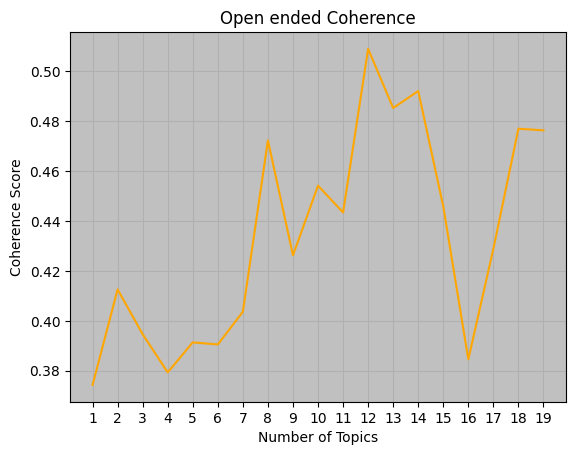

In [33]:
coherence_plot(topics_cv, score_cv, plot_title='Open ended Coherence' ,filename='bb_open_ended_coherence.png')

## Print Topics

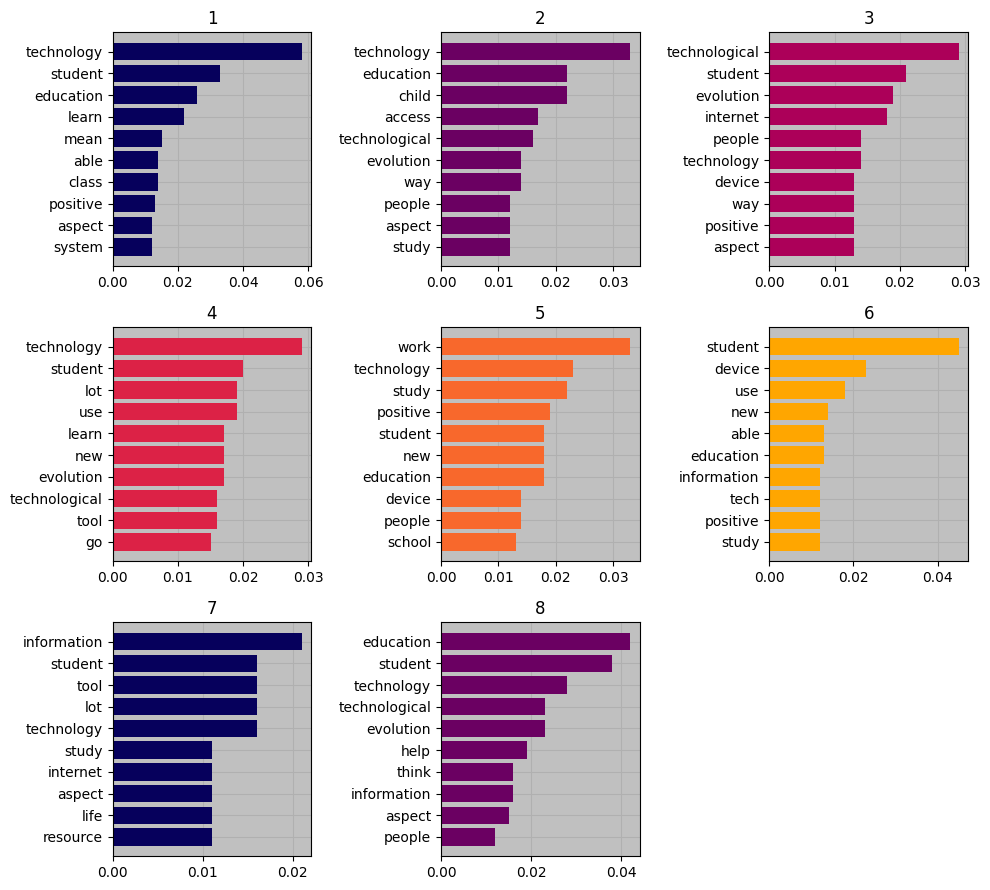

In [34]:
# topics_to_graph(open_lda_model, plot_title='Open ended topics', filename='ba_open_ended_MT.png')
topics_to_graph(open_lda_model, plot_title='Open ended topics')

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(open_lda_model, open_corpus, open_dictionary)
pyLDAvis.display(lda_display)

#  Close ended

In [37]:
closed_ended = fid_list[fid_list['fid'].isin(cefid)]
closed_ended_alt = fid_list[fid_list['fid'].isin(cefid_alt)]

## Get Tokens

In [38]:
closed_ended['tokens'] = closed_ended['doc'].apply(get_doc_tokens)
closed_ended

/home/polayala/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,fid,pid,level,individual_level,fs_answer,standarized,lang,doc,length,length_clean,length_special,task_type,tokens
466,386,NaN,0.0,0,Scalability: The possibility for more NGOs to ...,scalability: the possibility for more ngos to ...,en,"(scalability, :, the, possibility, for, more, ...",78,68,10,Close,"[scalability, possibility, ngo, join, effort, ..."
467,386,NaN,0.0,0,Resource access and sharing: Now they have dec...,resource access and sharing: now they have dec...,en,"(resource, access, and, sharing, :, now, they,...",107,99,8,Close,"[resource, access, sharing, decide, join, effo..."
468,386,NaN,0.0,0,Openness and resource sharing are very related...,openness and resource sharing are very related...,en,"(openness, and, resource, sharing, are, very, ...",315,289,26,Close,"[openness, resource, sharing, relate, second, ..."
469,386,NaN,0.0,0,Resource access and sharing: they can share th...,resource access and sharing: they can share th...,en,"(resource, access, and, sharing, :, they, can,...",38,32,6,Close,"[resource, access, sharing, share, datum, coll..."
470,386,NaN,0.0,0,Scalability -> An increase of scalability by m...,scalability > an increase of scalability by ma...,en,"(scalability, >, an, increase, of, scalability...",91,83,8,Close,"[scalability, increase, scalability, make, pro..."
471,386,NaN,0.0,0,The technologies used by these databases and t...,the technologies used by these databases and t...,en,"(the, technologies, used, by, these, databases...",63,58,5,Close,"[technology, database, tool, diverse, heteroge..."
472,386,NaN,0.0,0,"In this case we can identify SCALABILITY, as i...","in this case we can identify scalability, as i...",en,"(in, this, case, we, can, identify, scalabilit...",91,90,1,Close,"[case, identify, scalability, able, adapt, new..."
473,386,NaN,0.0,0,Heterogeneity -> There is a lot of heterogenei...,heterogeneity > there is a lot of heterogeneit...,en,"(heterogeneity, >, there, is, a, lot, of, hete...",177,159,18,Close,"[heterogeneity, lot, heterogeneity, ngo, share..."
474,386,NaN,0.0,0,Fault-tolerance: Given the importance of their...,faulttolerance: given the importance of their ...,en,"(faulttolerance, :, given, the, importance, of...",58,54,4,Close,"[faulttolerance, give, importance, action, wor..."
475,386,NaN,0.0,0,The main non-functional requirement in this ca...,the main nonfunctional requirement in this cas...,en,"(the, main, nonfunctional, requirement, in, th...",224,202,22,Close,"[main, nonfunctional, requirement, case, resou..."


## Create dictionary and corups

In [39]:
closed_dictionary = Dictionary(closed_ended['tokens'])
closed_corpus = [closed_dictionary.doc2bow(doc) for doc in closed_ended['tokens']]

##  Train

In [21]:
closed_lda_model = LdaMulticore(corpus=closed_corpus, id2word=closed_dictionary, iterations=50, num_topics=9, workers = 4, passes=10)

## Coherence

### C_v

In [48]:
topics_cv, score_cv = get_coherence_scores(closed_corpus, closed_dictionary, closed_ended['tokens'], coherence_model='c_v')

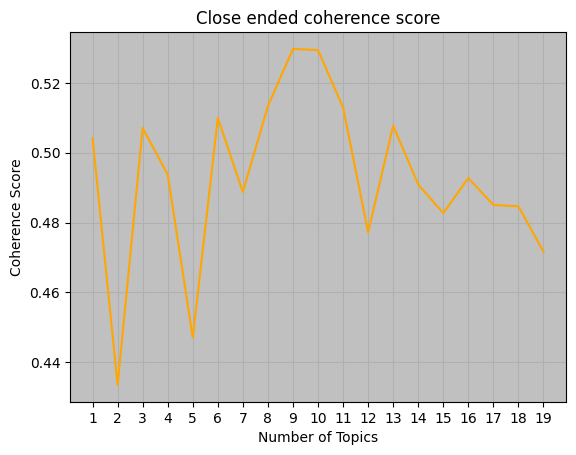

In [49]:
coherence_plot(topics_cv, score_cv, plot_title='Close ended coherence score', filename='bb_close_ended_coherence.png')

## Print Topics

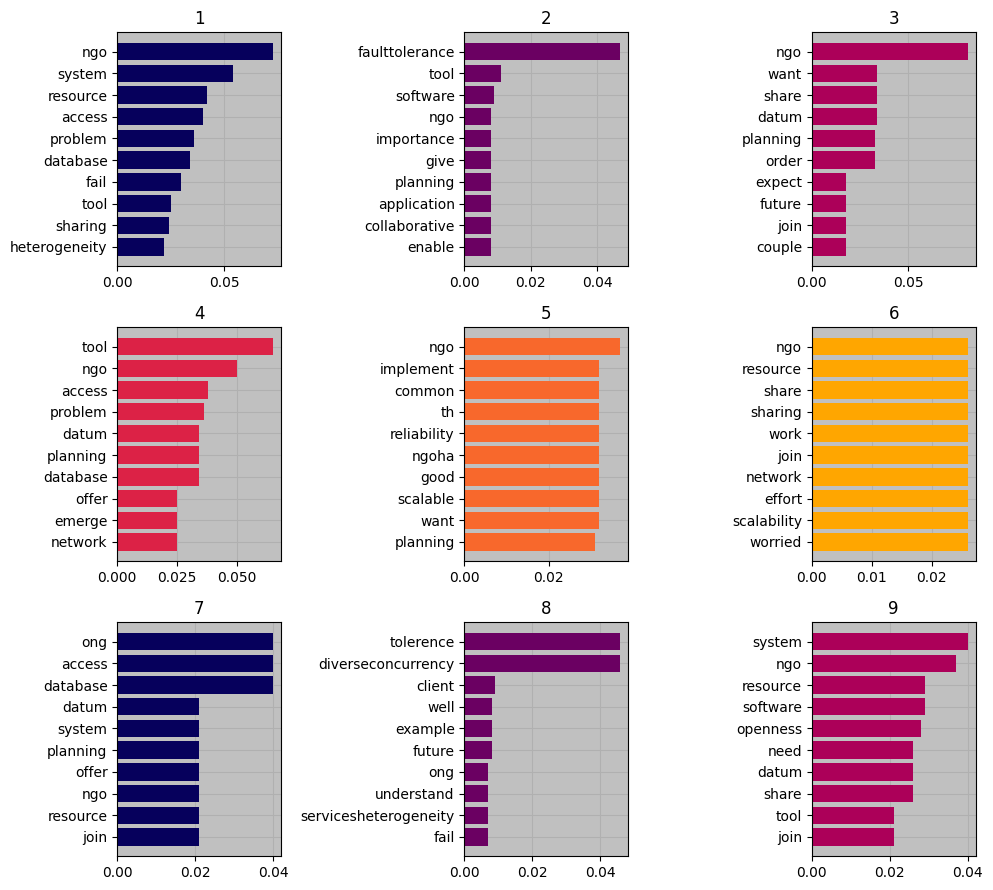

In [53]:
# topics_to_graph(closed_lda_model, plot_title='Close ended topics', filename='ba_close_ended_MT.png')
topics_to_graph(closed_lda_model, plot_title='Close ended topics')

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(closed_lda_model, closed_corpus, closed_dictionary)
pyLDAvis.display(lda_display)